<style>
@import url(https://www.numfys.net/static/css/nbstyle.css);
</style>
<a href="https://www.numfys.net"><img class="logo" /></a>

# Oil Spill

### Examples - Fluid Mechanics
<section class="post-meta">
By Tor Nordam, Jonas Blomberg Ghini, Jon Andreas Støvneng, Eilif Sommer Øyre and Jonas Tjemsland
</section>
Last edited: March 22nd 2018

This notebook is based on a project assignment [[1]](#rsc) given in the course TMA4320 Introduction to Scientific Computation at NTNU, spring 2017.
___

## Introduction
It is probably well known that the Norwegian Meteorological Institute produces a weather forecast, predicting the weather several days into the future. This weather forecast includes a vector field of air velocities at 10 m elevation above the ground, commonly known as “the wind”. Less well known is that they also produce a forecast for the ocean, which includes a velocity field describing the ocean currents about two days into the future. In the event of an oil spill at sea, this informationcan be used to predict where the oil will end up, which in turn can be used to direct response operations to try to minimise the damage. During for example the Deepwater Horizon oil spill in the Gulf of Mexico in 2010, numerical simulations were used daily to predict what would happen over the next few days. 

The goal of this notebook is to simulate transport of matter by ocean currents. While oil spills at sea are relatively well known from media coverage, it is by no means an easy task to simulate what happens. Oil spilled at sea displays quite complex behaviour: it can form droplets submerged in the water, continuous slicks at the surface, it will partially dissolve, partially evaporate and partially biodegrade, and it can form stable oil-in-water emulsions, all of which will significantly alter its properties. For these reasons, we will study the simpler case of transport of a dissolved chemical. A dissolved chemical will move in the same way as the surrounding water, without sinking or rising due to differences in density.

We will study the transport of dissolved chemicals in the ocean using a particle method. We will read data which are provided by the Norwegian Meteorological Institute (MET), interpolate these data and use them to calculate trajectories. We will also plot positions and concentration fields on a map, using various python library packages.

## Background and Theory

In our simulations, we will represent the dissolved matter as numerical particles, also called “Lagrangian elements”. The idea is that a numerical particle will represent a given amount of dissolved matter. This is not to be interpreted as an actual, physical particle, but simply as a numerical approximation. If we have large numbers of numerical particles, they can be used to calculate concentration, which is proportional to the density of particles (that is, the number of particles in a volume).

We assume that the presence of the particles don’t affect the motion of the water, so we can take the velocity of the water as a given.

We also assume that the particle always moves with the same velocity as the water. This is essentially the same as saying the particle has no inertia. In this model, if you give the particle some velocity, and release it, the motion will immediately be damped, due to friction against the water. It is therefore called the overdamped limit. This model is described by the ODE

\begin{equation}
\dot{\textbf{x}} = \textbf{v}_w(\textbf{x}, t),
\label{eq:1}
\end{equation}

where $\dot{\textbf{x}}$ is the velocity vector of the particle and $\textbf{v}_w(\textbf{x}, t)$ is the velocity (current) of the water at position $\textbf{x}$ and time $t$ .

When the drag coefficient between the water and the particle is large, the overdamped limit is a good approximation.

## Oceanographic data

In this example, we will use pre-calculated ocean current data to tell us the velocity of the water, $\textbf{v}_w$, as a function of $\textbf{x}$ and $t$. The oceanographic data are produced by MET, and they are the results of running a numerical simulation engine known as ROMS, on a model domain known as NorKyst800m. It provides information about current velocities, water temperature and salinity for an area covering the entire Norwegian coast, at 800m × 800m horizontal resolution, with 12 vertical layers, and with a time resolution of 1 hour. 

The data are available for download as NetCDF [[2]](#rsc)  files, or the data can be accessed via OPeNDAP [[3]](#rsc). NetCDF is  a file format for storing data in arrays. It is quite well suited for medium to large amounts of data (up to 100's of gigabytes in a single file works fine), and it is very commonly used for geographical data, such as ocean or atmosphere data. In order to access the data, we will use the python library `xarray` [[4]](#rsc). 

The data files contain the $x$ and $y$ components of the velocity field, stored in two variables named $u$ and $v$ (it is quite common to store only the horizontal components of the current velocity). These variables are stored as rank 4 arrays, which give their values as a function of time, depth, y position and x position (note that the order of the dimensions in the files is $(t, z, y, x)$). The coordinates of the grid points along these dimensions are also stored in the data files, in the variables $time$, $depth$, $Y$, and $X$. For simplicity, we will ignore the depth dimension, dealing only with movement in the horizontal plane, and time.

In Fig. [1](#im1), temperature data for the surface water is shown, as an example to illustrate the extent of the available data. In Fig. [2](#im2), the same data are shown in the coordinate system used in the file, with the $x$ coordinates on the horizontal axis, and the $y$ coordinates on the vertical. The origin of the coordinate system is at the North Pole.

The dimensions $x$ and $y$, as shown in Fig. [2](#im2), are the coordinate axes in what is known as a polar stereographic projection of the Earth’s surface onto a plane. For the purpose of this project, we will deal with motion in the $xy$-plane, with coordinates as shown. As the vector components of the velocity field are aligned with these coordinate axes, we can use the components directly to calculate motion in the $xy$-plane. This means that for the transport simulations, we will ignore the curvature of the Earth. In the end, we will see how to transform from $xy$-coordinates to longitude and latitude, and plot the particle positions on a map.

<a name="im1"></a>
<img src="https://www.numfys.net/media/notebooks/images/domain.png" width="600">
**Figure 1:** *The domain of the NorKyst800m model, showing surface water temperatures on February 4, 2017.*

<br />
<a name="im2"></a>
<img src="https://www.numfys.net/media/notebooks/images/stereographic_projection.png" width="650">
**Figure 2:** *The domain of the NorKyst800m model, shown in the coordinate system used to store the data. The origin of the coordinate system is at the North pole (marked with ×), and the distances are in meters.*

<a name="im3"></a>
<img src="https://www.numfys.net/media/notebooks/images/grid.png" width="350">
**Figure 3:** *Velocity vector components are given only on discrete points, $(x_i, y_j) = (x_0 + i\Delta x, y_0+j\Delta y)$. In order to calculate trajectories, we need to evaluate the velocity at arbitrary positions $(x, y)$* 

## Plotting on maps

After calculating how the particles are transported with the ocean currents, we will plot their trajectories and positions on a map. There are two main libraries in use to plot data on maps with python, `basemap` and `cartopy`. In this example, we will use `cartopy` [[5]](#rsc), which is slightly easier to use. `cartopy` is a Python package designed to make drawing maps for data analysis and visualisation as easy as possible. 

When moving particles around with the water velocity, we will use the coordinate system shown in Fig. [2](#im2). For plotting trajectories, it is straightforward to just use those coordinates directly, which will show distances in meters. However, if we want to show the trajectories on a map, we need to convert from the $xy$ coordinatesystem of the polar stereographic projection, to longitude and latitude. We will use a library called `pyproj` [[6]](#rsc). This Python package performs cartographic transformations and geodetic computations. The class `pyproj.Proj` can convert from geographic (longitude, latitude) to native map projection $(x,y)$ coordinates and vice versa, or from one map projection coordinate system directly to another. 

## The Problem

We want to represent the transport of a dissolved chemical in the ocean, by simulating the motion of a large number of particles. A particle’s trajectory is controlled by Eq. \eqref{eq:1}, where $\textbf{v}_w$ is taken from the ocean current data. The prepared datafile `Norkyst-800m.nc` containins 20 days of data spanning from February 1 to February 20, 2017. The file is available for download here:
* http://folk.ntnu.no/nordam/data/Norkyst-800m.nc

The motion of any one particle is not affected by the presence of other particles. We start out with a collection of $N_p$ particles, each particle at a position $\textbf{x}_0$ at $t = 0$, randomly placed in the square defined by $−3010000 < x < −2990000$ , $−1210000 < y < −1190000$. All particles are transported with the ocean current for a time of 10 days.

To propagate the particles we use the Explicit Trapezoid Method as an integrator. The timestep is set to $h = 3600$ s and since the data is provided at intervals of one hour, no interpolation in time is needed.

We will now do the following:


### Tasks

**a.** Plot he position of the particles on a map at $t = 0$, and after $2$, $4$, $6$, $8$, and $10$ days.

**b.** Calculate and plot the chemical concentrations on a map after $2$, $4$, $6$, $8$, and $10$ days.

## The Solution

First, we import needed python packages.

In [1]:
%matplotlib inline
from time import time
from datetime import datetime, timedelta
import numpy as np
from matplotlib import pyplot as plt
# nicer looking default plots
plt.style.use('bmh')

# Library to read data from NetCDF files
import xarray as xr

# 2D spline interpolation routine
from scipy.interpolate import RectBivariateSpline

# Map plotting library
import cartopy
# The subclass CRS contains all types of coordinate
# reference systems. We will mainly be using the 
# projection NorthPolarStereo
import cartopy.crs as ccrs
# The subclass feature represents a collection of points, 
# lines, and polygons with convenience methods for common 
# drawing and filtering operations.
import cartopy.feature as cfeature

# library for coordinate transformations
import pyproj

### Utility functions
As an in-memory representation of the NetCDF-file, `Norkyst-800m.nc`, we use the `xarray` data structure `xarray.dataset`. It is a dictionary-like container of labeled arrays with aligned dimensions. Its dictionary-like interface can be used to access any variable in the dataset. Read more about `xarray.dataset` [here](http://xarray.pydata.org/en/stable/data-structures.html#dataset).

In this example the $x$ and $y$ components of the velocity field are stored as `u` and `v` and the grid coordinates as the arrays `X`, and `Y`. The time variable `time` is stored as a `datatime64` type. An array of specific velocity component values at the grid coordinates $(x_0, y_0), ..., (x_i, y_i)$ is returned by running ```dataset.u[time, depth, y0:yi, x0:xi]```.


In [2]:
datapath = "~/downloads/NorKyst-800m.nc"
d  = xr.open_dataset(datapath)

Now, we define a few utility functions. 

To interpolate the velocity $\textbf{v}_w$ to an arbritary point $(x, y)$ on the $xy$ coordinate system, we use the class `RectBivariateSpline` from `scipy.interpolate`, as discussed earlier. This is implemented in the class `Interpolator`,
as defined beneath. `Interpolator` has the datafile representation `dataset` as a member variable.

In [3]:
class Interpolator():
    """ Interpolating the datasets velocity components using bivariate spline
    interpolation over a rectangular mesh.
    The memberfunction get_interpolators returns functions for the 
    velocity components' interpolated value at arbitrary positions.
    
    Parameters
    ----------
    dataset : xarray_type
            Data structure containing the oceanographic data.
    X       : array_type
            Particle coordinates.
    t       : datetime64_type
            Time.
    ----------
    """
    def __init__(self, dataset):
        self.dataset = dataset
        
    def get_interpolators(self, X, it):
        # Add a buffer of cells around the extent of the particle cloud
        buf  = 3
        # Find extent of particle cloud in terms of indices
        imax = np.searchsorted(self.dataset.X, np.amax(X[0,:])) + buf
        imin = np.searchsorted(self.dataset.X, np.amin(X[0,:])) - buf
        jmax = np.searchsorted(self.dataset.Y, np.amax(X[1,:])) + buf
        jmin = np.searchsorted(self.dataset.Y, np.amin(X[1,:])) - buf
        # Take out subset of array, to pass to RectBivariateSpline
        # Transpose to get regular order of coordinates (x,y)
        # Fill NaN values (land cells) with 0, otherwise
        # interpolation won't work
        u    = self.dataset.u[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        v    = self.dataset.v[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        # RectBivariateSpline returns a function-like object,
        # which can be called to get value at arbitrary position
        fu   = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u)
        fv   = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v)
        return fu, fv

    def get_time_index(self, t):
        # Get index of largest timestamp smaller than (or equal to) t
        return np.searchsorted(self.dataset.time, t, side='right') - 1

    def __call__(self, X, t):
        # get index of current time in dataset
        it = self.get_time_index(t)
        # get interpolating functions,
        # covering the extent of the particle
        fu, fv = self.get_interpolators(X, it)
        # Evaluate velocity at position(x[:], y[:])
        vx = fu(X[0,:], X[1,:], grid = False)
        vy = fv(X[0,:], X[1,:], grid = False)
        return np.array([vx, vy])

To solve the ODE $\eqref{eq:1}$, we need an integrator. In this example we make use of The Explicit Trapezoid which is a second-order Rung-Kutta method.

In [4]:
def rk2(x, t, h, f):
    """ A second order Rung-Kutta method.
        The Explicit Trapezoid Method.
        
    Parameters:
    -----------
        x :    coordinates (as an array of vectors)
        h :    timestep
        f :    A function that returns the derivatives
    Returns:
        Next coordinates (as an array of vectors)   
    -----------
    """

    # Note: t and h have actual time units.
    # For multiplying with h, we need to
    # convert to number of seconds:
    dt = h / np.timedelta64(1, 's')
    # "Slopes"
    k1  = f(x,           t)
    k2  = f(x + k1*dt,   t + h)
    # Calculate next position
    x_ = x + dt*(k1 + k2)/2
    return x_

Finally, we define a function to calculate the trajectory of the particles.

In [5]:
def trajectory(X0, t0, Tmax, h, f, integrator):
    """ Function to calculate trajectory of the particles.
    
    Parameters:
    -----------
        X0 :    A two dimensional array containing start positions 
                (x0, y0) of each particle.
        t0 :    Initial time
        Tmax:   Final time
        h  :    Timestep
        f  :    Interpolator
        integrator:   The chosen integrator function
    
    Returns:
        A three dimensional array containing the positions of
        each particle at every timestep on the interval (t0, Tmax).
    -----------
    """
    
    Nt   = int((Tmax-t0) / h)          # Number of datapoints
    X    = np.zeros((Nt+2, *X0.shape))
    X[0,:] = X0
    t = t0
    for i in range(Nt+1):
        # Adjust last timestep to match Tmax exactly
        h  = min(h, Tmax - t)
        t += h
        X[i+1,:] = integrator(X[i,:], t, h, f)
    return X

### Task a.

- Calculate trajectory of $N_p$ particles, and plot positions on a map after 0, 2, 4, 6, 8 and 10 days.

In [6]:
# Initialise interpolator with dataset
datapath = "~/downloads/NorKyst-800m.nc"
d  = xr.open_dataset(datapath)
f  = Interpolator(dataset = d)

# Set initial conditions (t0 and x0) and timestep
# Note that h also has time units, for convenient
# calculation of t + h.
h  = np.timedelta64(3600, 's')
# setting X0 in a slightly roundabout manner for
# compatibility with Np >= 1
Np = 10000
X0 = np.zeros((2, Np))
X0[0,:] = np.random.uniform(-3010000, -2990000, size = Np)
X0[1,:] = np.random.uniform(-1210000, -1190000, size = Np)

# Dataset covers 2017-02-01 00:00 to 2017-02-19 23:00
t0   = np.datetime64('2017-02-01T12:00:00')
# Calculate 10 day trajectory
Tmax = t0 + np.timedelta64(10, 'D')
X1   = trajectory(X0, t0, Tmax, h, f, rk2)

The array `X1` now contains the $xy$ coordinate for each of the $N_p$ particles at each time $t$. It has the dimensions `(Nt, 2, Np)`.
Now, we are able to plot the particles on a map at any time we want, as well as counting the concentration of particles in a defined grid system. To create a figure with stereographic projection we use `ccrs`, to add coastlines and other features we use `cfeature`, and to transform the cartesian coordinates to longitude and latitudes we use `pyproj`.

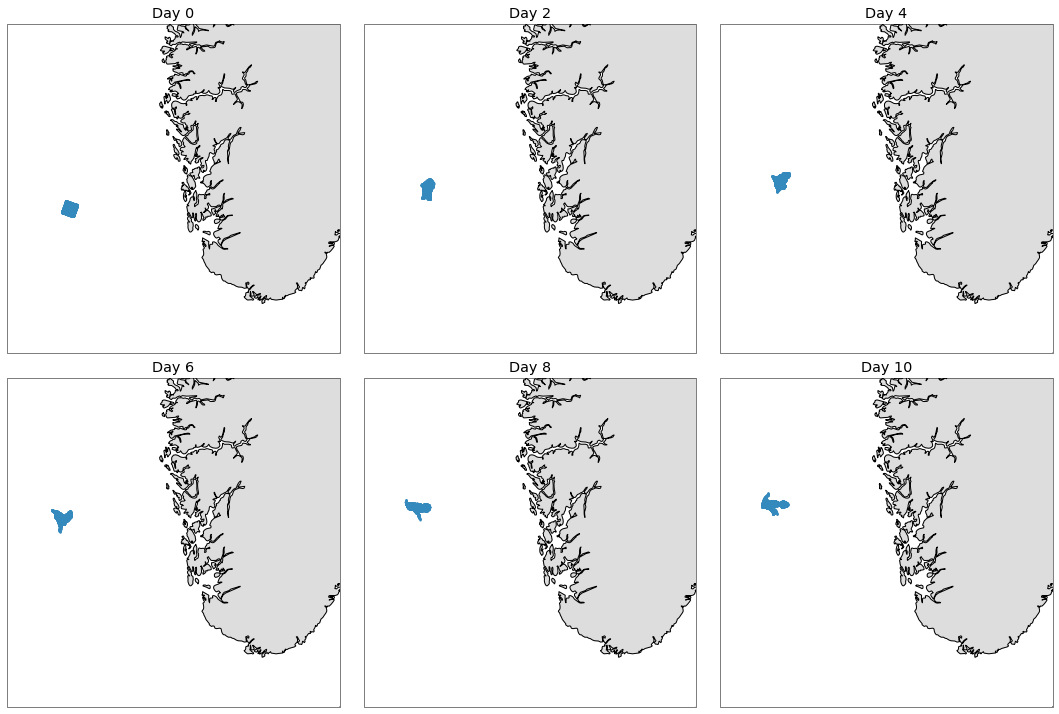

In [7]:
# PLOTTING PARITCLES ON MAP
# Step 1 
# Create a figure object, and add 6 axes instances, with projection info
fig = plt.figure(figsize=(15,10))
axes = []
axes.append(fig.add_subplot(231, projection=ccrs.NorthPolarStereo()))
axes.append(fig.add_subplot(232, projection=ccrs.NorthPolarStereo()))
axes.append(fig.add_subplot(233, projection=ccrs.NorthPolarStereo()))
axes.append(fig.add_subplot(234, projection=ccrs.NorthPolarStereo()))
axes.append(fig.add_subplot(235, projection=ccrs.NorthPolarStereo()))
axes.append(fig.add_subplot(236, projection=ccrs.NorthPolarStereo()))

# Step 2:
# It doesn't look like a map unless we add land and sea
# In order to draw land and coastlines, we use built-in functions
# in cartopy.feature. These will download some data from
# www.naturalearthdata.com/ the first time they are called.
# (resolution 10m means 1 : 10,000,000, not 10 meters)
land_10m  = cfeature.NaturalEarthFeature('physical', 'land', '10m', color = '#dddddd')
for ax in axes:
    # Add land and coastline
    ax.add_feature(land_10m)
    ax.coastlines(resolution='10m')

# Create projection with metadata from dataset
# and latlon projection
p1 = pyproj.Proj(d.projection_stere.proj4)
p2 = pyproj.Proj(proj='latlong')

# Step 3:
# Convert coordinates to longitude and latitude
lons, lats = pyproj.transform(p1, p2, X1[:,0,:], X1[:,1,:])

# Step 4:
# Plot data
for i, it in enumerate(np.arange(0, 10*24 + 1, 2*24)): # (start, stop (after 10 days), step (2 days))
    axes[i].set_title("Day " + str(0 + 2*i))
    axes[i].scatter(lons[it,:], lats[it,:], marker = '.', lw = 0, s = 20, alpha = 0.8, 
                    transform=ccrs.Geodetic(), zorder=2)

# Step 5 (optional):
# Set the extent of the map. If we leave out these, it would
# just cover the plotted points, and nothing more. Specify
# (lon0, lon1, lat0, lat1), and Cartopy will make sure the
# map area is large enough to cover the four points
# (lon0, lat0), (lon0, lat1), (lon1, lat0), (lon1, lat1).
for ax in axes:
    ax.set_extent((0, 9, 57.5, 62))

# try to automatically reduce white space in figure
plt.tight_layout()

As expected, the results shows that the chemical trajects rather collectivly, with little deformation of shape during the first four days. We see that the group moves mainly northwards. The small spreading indicates only slight local differences in the ocean current.

### Task b.

- Calculate gridded concentration by counting particles in cells. 

The coordinates of the particles are already stored in the array `X1`. We now only need to define the grid system and count the number of particles in each grid cell. The latter is stored in the two dimensional array `counts`, where each element represents the concentration of the chemical to the corresponding 800m × 800m grid cell. The concentration is then illustrated by plotting a quadrilateral mesh using the `matplotlib.axes` function `pcolormesh`. Grid cells with the lowest concentration are coloured purple, and grids with the highest concentrations are coloured yellow. A masked array is used to only plot those cells with nonzero concentrations.

The function `plt.pcolormesh()` basically plots each element of a 2D array as a tiny rectangle. For each tiny rectangle, it needs to know three things: $x$-coordinate, $y$-coordinate, and value. The values are the counts. The coordinates must be transformed from 1D arrays to 2D arrays, of the same shape as the counts. For this, `np.meshgrid` is used. To count the particles in each grid, we use the `numpy` function `np.histogram2d`. As parameters this function needs the $x$ and $y$ coordinates of the points to be histogrammed, as well as a bin specification, which in this case is the extent of the grid system.

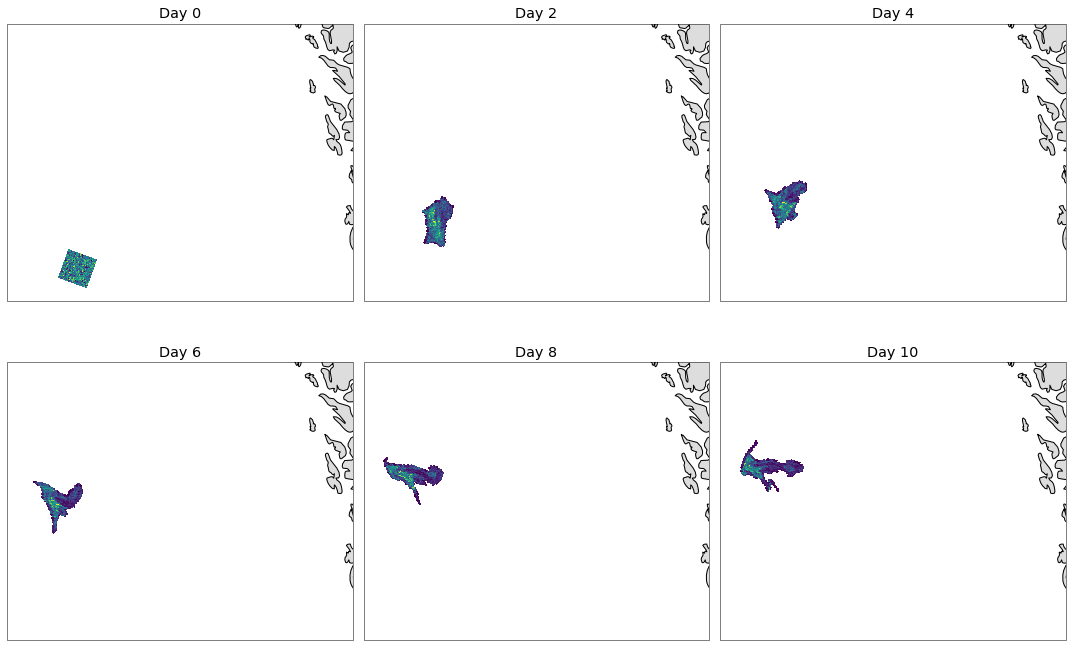

In [8]:
# CALCULATING AND PLOTTING GRIDDED CONCENTRATION
# Creating figure, axes and plotting features as in task a.
fig = plt.figure(figsize=(15, 10))
land_10m  = cfeature.NaturalEarthFeature('physical', 'land', '10m', color='#dddddd')
axes = []
axes.append(fig.add_subplot(231, projection=ccrs.NorthPolarStereo()))
axes.append(fig.add_subplot(232, projection=ccrs.NorthPolarStereo()))
axes.append(fig.add_subplot(233, projection=ccrs.NorthPolarStereo()))
axes.append(fig.add_subplot(234, projection=ccrs.NorthPolarStereo()))
axes.append(fig.add_subplot(235, projection=ccrs.NorthPolarStereo()))
axes.append(fig.add_subplot(236, projection=ccrs.NorthPolarStereo()))

for ax in axes:
    # Add land and coastline
    ax.add_feature(land_10m)
    ax.coastlines(resolution='10m')
    # Set the extent of the map. (lon0, lon1, lat0, lat1)
    ax.set_extent((1, 5.1, 59.4, 61))

# Create projection with metadata from dataset
# and latlon projection
p1 = pyproj.Proj(d.projection_stere.proj4)
p2 = pyproj.Proj(proj='latlong')

# Plot concentrations on the map.
for i, it in enumerate(np.arange(0, 241, 48)):
    # Particle positions at current time
    x = X1[it, 0, :]
    y = X1[it, 1, :]
    
    # Grid size (m)
    wid = 800
    # Uses the particles position to define the extent of the grid system, for each time.
    Xcoords = np.arange(np.amin(x) - 2*wid, np.amax(x) + 2*wid, wid)
    Ycoords = np.arange(np.amin(y) - 2*wid, np.amax(y) + 2*wid, wid)
    
    # To count particles in each cell, we use numpy.histogram2d
    counts, edgeX, edgeY = np.histogram2d(x, y, bins = (Xcoords, Ycoords))
    # Use bin edges returned by function as coordinates
    edgeX, edgeY = np.meshgrid(edgeX, edgeY)
    # Convert coordinates
    lons, lats = pyproj.transform(p1, p2, edgeX, edgeY)

    # Finally, we have chosen to use a masked array to plot
    # the grid data. This is mainly for visibility, as it avoids
    # plotting those cells where the value is 0.
    # Note that mask = True means that the element is not plotted
    # (because it is hidden behind the mask)
    # We use counts == 0 as the mask
    counts_masked = np.ma.masked_array(counts, mask = counts == 0)
    axes[i].pcolormesh(lons, lats, counts_masked.T, transform=ccrs.PlateCarree(), zorder=2)
    axes[i].set_title("Day " + str(0 + 2*i))

plt.tight_layout()

For a closer look at the concentration after ten days, we change the extent.

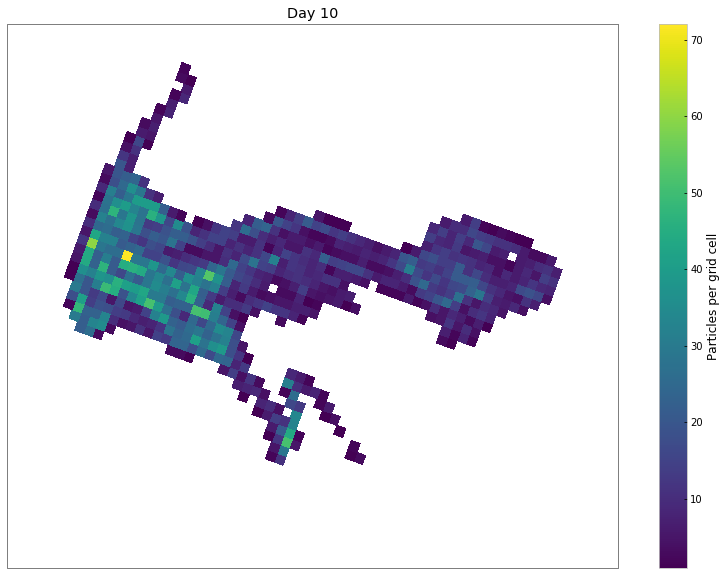

In [9]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.coastlines(resolution='10m')
# Set extent to match extent of grid system
ax.set_extent((np.amin(lons), np.amax(lons), np.amin(lats), np.amax(lats)))
cbar = ax.pcolormesh(lons, lats, counts_masked.T, transform=ccrs.PlateCarree(), zorder=2)
fig.colorbar(cbar, orientation="vertical", label="Particles per grid cell")
ax.set_title("Day 10")
plt.show()

## Conclusion

We have now succsessfully completed a simplified simulation of the movement of a chemical for a period of ten days after a spill, using a representation by numerical particles and assuming the particles moved with the same velocity as the water.

The particles were transported by the ocean currents retrieved from a NetCDF-file and represented in an xarray. The gridded velocity components of the current were interpolated using a scipy-function, and the trajectory of the numerical particles were calculated using the Explicit Trapezoid Method as integrator with a time step of an hour.

Finally, the position and the concentration of the oil were plotted on a map using the Python packages `cartopy` and `pyproj`.

<a name="rsc"></a>

## Resources and Further Readings


<a >[1]</a>:  Tor Nordam, Jonas Blomberg Ghini, Jon Andreas Støvneng. *Project Assignment: Particle-based simulation of transport by ocean currents*, 2017.<br />
<a>[2]</a>:   Network common data form, see [www.unidata.ucar.edu/software/netcdf/](http://www.unidata.ucar.edu/software/netcdf/).<br />
<a >[3]</a>:  Open-source Project for a Network Data Access Protocol, see [www.opendap.org](http://www.opendap.org).<br />
<a >[4]</a>:  XArray.dataset doc @[www.xarray.pydata.org](http://xarray.pydata.org/en/stable/data-structures.html#dataset).<br />
<a >[5]</a>:  For more Cartopy reference systems and map axes features, see [cartopy](http://scitools.org.uk/cartopy/docs/v0.13/index.html).<br />
<a >[6]</a>:  Pyproj docs @[github](http://jswhit.github.io/pyproj/).<br />